# Supplemental Material: SAI Storylines under GAUSS

In [1]:
# __authors__: Elizabeth Barnes and Patrick Keys
# __date__: Aug 01, 2022

In [2]:
import importlib as imp
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import datetime
from icecream import ic

import data_processing_gauss, plots

import cartopy as ct
import palettable
from matplotlib.colors import ListedColormap
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
savefig_dpi = 300
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
import warnings
warnings.filterwarnings("ignore")



FS = 10
plt.rc('text',usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')

map_proj = ct.crs.EqualEarth(central_longitude = 0.)

In [3]:
TREND_YEARS_GAUSS = (2035,2044)
WARMING_CUTOFF = 0.01
VARIABLE = "TREFHT"

DATA_DIRECTORY = 'data/'
FIGURE_DIRECTORY = 'figures/supp_gauss/'

## Get the data

In [4]:
imp.reload(data_processing_gauss)
mask = data_processing_gauss.get_land_mask(DATA_DIRECTORY + 'sftlf_fx_CESM2-WACCM_historical_r1i1p1f1_gn.nc', var="sftlf")
da_all = data_processing_gauss.get_data(DATA_DIRECTORY, VARIABLE)


ensemble member = 001
ensemble member = 002
ensemble member = 003
(3, 35, 192, 288)


In [5]:
imp.reload(data_processing_gauss)
da_all_mean = da_all.mean("member")

da_mean_trends_gauss35 = data_processing_gauss.compute_trends(da_all_mean, TREND_YEARS_GAUSS[0], TREND_YEARS_GAUSS[0]+34)
ic(da_mean_trends_gauss35.shape)

da_trends_gauss = data_processing_gauss.compute_trends(da_all, TREND_YEARS_GAUSS[0], TREND_YEARS_GAUSS[1])
ic(da_trends_gauss.shape)


ic| da_mean_trends_gauss35.shape: (2, 192, 288)
ic| da_trends_gauss.shape: (2, 3, 192, 288)


(2, 3, 192, 288)

In [6]:
# error('here')

## Figure 1

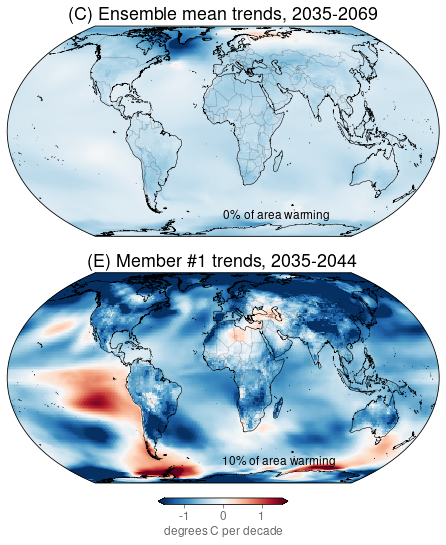

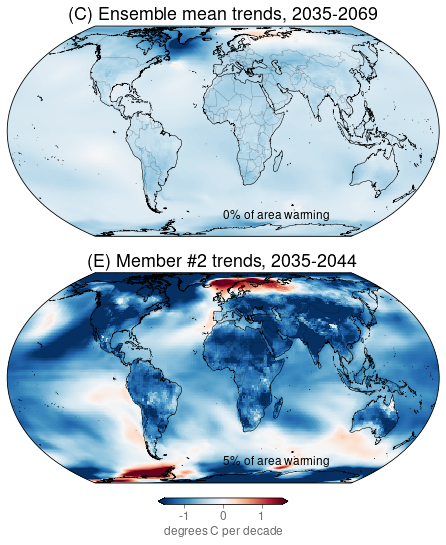

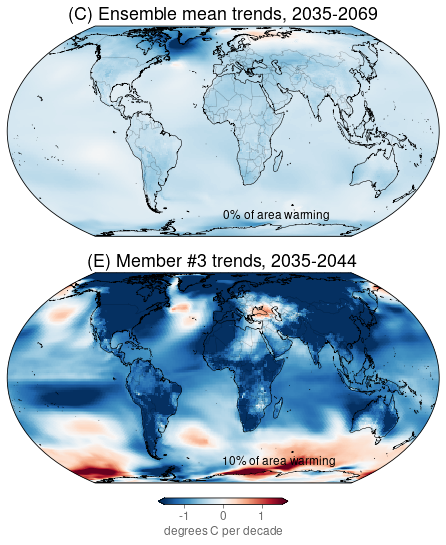

In [7]:
imp.reload(plots)
MULT_FACTOR = 10
FS = 12

for PLOT_MEMBER in (0,1,2):
    #------------------------
    # fig = plt.figure(figsize=(13,3*3))
    fig = plt.figure(figsize=(5.0*1.5*2*.8,3.75*1.3*3*.8))
    spec = fig.add_gridspec(ncols=4, nrows=3, height_ratios=[.75,1,1], width_ratios=[1,.6,.6,1])
    vbound = 0.15*MULT_FACTOR
    #------------------------
    
    for MASK_BOOL in (False,):
        for data_type in ("all","member"):
            for start_year in (2035,):

                if data_type=="member":
                    da_plot = da_trends_gauss[0,PLOT_MEMBER,:,:].squeeze()
                    title_text = "(E) Member \#" + str(PLOT_MEMBER+1) + " trends, 2035-2044"               
                    specs = (2,2)
                elif data_type=="all":
                    da_plot = da_mean_trends_gauss35[0,:,:].squeeze()
                    title_text = "(C) Ensemble mean trends, " + "2035-2069"
                    specs = (1,2)


                if MASK_BOOL:
                    da_plot_member = da_plot * mask
                    da_positive_trends = np.ceil(np.abs(da_plot_member.where(da_plot_member>=WARMING_CUTOFF,0.,drop=False)))
                    da_positive_trends = da_positive_trends * mask
                else:
                    da_plot_member = da_plot
                    da_positive_trends = np.ceil(np.abs(da_plot_member.where(da_plot_member>=WARMING_CUTOFF,0.,drop=False)))        
                frac = data_processing_gauss.compute_global_mean( da_positive_trends )

                ax = fig.add_subplot(spec[specs[0],specs[1]:specs[1]+2],projection=map_proj)
                cb,image = plots.drawOnGlobe(ax, 
                                  map_proj, 
                                  data=da_plot_member*MULT_FACTOR, 
                                  lats=da_plot_member["lat"],
                                  lons=da_plot_member["lon"],
                                  cmap='RdBu_r',
                                  vmin= -vbound, 
                                  vmax= vbound, 
                                  inc=None, 
                                  cbarBool=False, 
                                  contourMap=[], 
                                  contourVals = [], 
                                  fastBool=True, 
                                  extent='both',
                                 )   
                ax.text(0,-60,str(int((100*frac).round())) + '\% of area warming',color='black', fontsize=FS, transform=ct.crs.PlateCarree())

                image.set_clim(-vbound,vbound)
                ax.xaxis.set_visible(False)
                ax.yaxis.set_visible(False) 
                ax.set_title(title_text,fontsize=FS*1.5)

        #https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.tight_layout.html#matplotlib.pyplot.tight_layout
        # fig.tight_layout(rect=(0.025, 0.025, 0.95, 0.95))    #tuple (left, bottom, right, top), default: (0, 0, 1, 1); 
        # A rectangle in normalized figure coordinates into which the whole subplots area (including labels) will fit.
        fig.tight_layout(pad=1., h_pad=0., w_pad=-2)

        # set colorbar        
        axs = fig.axes
        bounds = np.round(np.arange(-.2,.29,.1),3)*MULT_FACTOR
        cb = fig.colorbar(image, ax=axs, 
                          shrink=0.3, 
                          ticks=bounds,
                          location='bottom',
                          pad=.025,
                          extend='both',
                          label='degrees C per decade',
                         )
        cb.set_ticklabels(['-2', '-1', '0', '1', '2'],fontsize=FS)
        cb.set_label(label='degrees C per decade',fontsize=FS)

        # plt.tight_layout() 
        plt.savefig(FIGURE_DIRECTORY + 'GAUSS_four_panel_trends_member' + str(PLOT_MEMBER) + '_' + VARIABLE + '_ensmean.png',  bbox_inches='tight', dpi=savefig_dpi)
        plt.show()

# Perceived Failures Frequency

In [14]:
(da_quad_1 + da_quad_2).sum("member").max()

<xarray.DataArray 'polyfit_coefficients' ()>
array(6)
Coordinates:
    degree   int64 1

<xarray.DataArray 'polyfit_coefficients' ()>
array(1.)
Coordinates:
    degree   int64 1


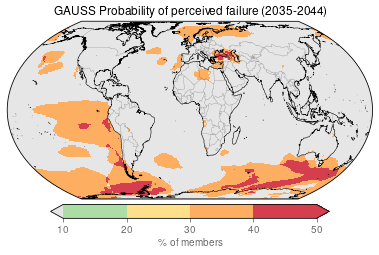

In [22]:
fig = plt.figure(figsize=(5.0*2*1.5*.9*.8,3.75*1.5*2*.75*.8),)#constrained_layout=True) #gridspec_kw={'width_ratios': [3, 2]})
spec = fig.add_gridspec(ncols=12, nrows=10)

MASK_BOOL = False

#-----------------------------------------------------------------
# PERCEIVED FAILURES
# ax = fig.add_subplot(2,2,1,projection=map_proj)
ax = fig.add_subplot(spec[:5,0:6],projection=map_proj)

cmap = plots.get_qual_cmap()
cmap = palettable.colorbrewer.diverging.Spectral_8_r.mpl_colors
cmap = np.delete(cmap,(0,1,3,6),0)
cmap = ListedColormap(cmap)

da_plot = da_trends_gauss[0,:,:,:].squeeze()
# da_plot_cntrl = da_trends_cntrl[0,:,:,:].squeeze()

da_quad_1 = xr.where(da_plot>=WARMING_CUTOFF, 1, 0) 
da_quad = (da_quad_1).sum("member")/len(da_plot["member"].values)
print(da_quad.max())

#---------------------
if MASK_BOOL:
    da_plot_member = da_quad.to_numpy() * mask.to_numpy()
else:
    da_plot_member = da_quad

cb,p = plots.drawOnGlobe(ax, 
                  map_proj, 
                  data=da_plot_member*100, 
                  lats=da_quad["lat"],
                  lons=da_quad["lon"],
                  cmap=cmap,
                  vmin= 10, 
                  vmax= 50, 
                  inc=None, 
                  cbarBool=False, 
                  contourMap=[], 
                  contourVals = [], 
                  fastBool=True, 
                  extent='both',
                 )   
   
p.set_clim(10,50)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
# p.cmap.set_over('k')
p.cmap.set_under('.9')
cbar = plt.colorbar(p,ax=ax,label='\% of members',ticks=np.arange(10,50+10,10), extend="both",orientation='horizontal',pad=.025,shrink=.7)
cbar.ax.set_xticklabels(np.arange(10,50+10,10)) 

ax.set_title('GAUSS Probability of perceived failure (2035-2044)')     


#-----------------------------------------------------------------
fig.tight_layout(pad=1.08, h_pad=1, w_pad=-4)
# plt.tight_layout()
plt.savefig(FIGURE_DIRECTORY + 'GAUSS_perceived_failure_figure4_' + str(TREND_YEARS_GAUSS[0]) + '_' + str(TREND_YEARS_GAUSS[1])  + '_' + VARIABLE + '.png', bbox_inches="tight", dpi=savefig_dpi)
plt.show()